In [2]:
import optproblems
from optproblems import continuous
#help(continuous)

from optproblems.continuous import  FletcherPowell, Schwefel,Vincent
#help(Vincent)
f =Vincent(num_variables=3)
f([0.3,1.2,3.5])

-0.4774045005683265

In [3]:
# evolution strategy (mu + lambda) of the ackley objective function
from numpy import asarray
from numpy import exp
from numpy import sqrt
from numpy import cos
from numpy import e
from numpy import pi
from numpy import argsort
from numpy.random import randn
from numpy.random import rand
from numpy.random import seed

import numpy as np
import scipy as sp
import random
import itertools
from dwave.system import DWaveCliqueSampler,DWaveSampler,EmbeddingComposite 
import neal
import dimod
from scipy import stats

# objective function
#def objective(v):
#    x, y = v
#    return -20.0 * exp(-0.2 * sqrt(0.5 * (x**2 + y**2))) - exp(0.5 * (cos(2 * pi * x) + cos(2 * pi * y))) + e + 20

# check if a point is within the bounds of the search
def in_bounds(point, bounds):
    # enumerate all dimensions of the point
    for d in range(len(bounds)):
        # check if out of bounds for this dimension
        if point[d] < bounds[d, 0] or point[d] > bounds[d, 1]:
            return False
    return True




def calculate_pairwise_distance_population(population):
    combinations = list(itertools.permutations(population, 2))
    #print(combinations)
    dists = []
    for i in combinations:
        dists.append(np.abs(np.linalg.norm(i[0]-i[1])))
    #print(dists)
    return np.mean(dists)
        
    


def select_individuals_quantum(population, scores, k, sampler):
    # Get population size
    population_size = len(population)
    #print(population_size)
    pop_index = list(range(population_size))
    #print(pop_index)
    alpha =10
    beta_ = 1000
    bqm = dimod.BinaryQuadraticModel.empty(dimod.BINARY)
    
    #scores = np.abs(np.array(scores))
    #scores = np.array(scores)/np.max(np.array(scores))
    #scores = scores.tolist()
    for idx, i_ in enumerate(pop_index):
        #if np.isfinite(i_):
            #i_ =0.
        bqm.add_variable(idx, (scores[idx]))*alpha
        #print(1+ i_*alpha)
    #dists = []
    for p0, p1 in itertools.combinations(pop_index, 2):
        #print(population[p0], population[p1])
        dist_ = np.abs(stats.pearsonr(population[p0], population[p1])[0])
        #dist_ = np.abs(np.linalg.norm(population[p0]-population[p1]))
        bqm.add_interaction(p0, p1, (dist_)*beta_)
        
        #dists.append(np.linalg.norm(population[p0]-population[p1]))
        #print(dist_)
    #dists = np.array(dists)/np.max(np.array(dists))
    #dists = dists.tolist()
    #for dist_ in dists:
        #bqm.add_interaction(p0, p1, -(dist_)*beta_)
        
    bqm.update(dimod.generators.combinations(pop_index, k, strength=100000))
    #sampler = DWaveCliqueSampler(solver=dict(qpu=True))
    #sampler = neal.SimulatedAnnealingSampler()
    sample_ = sampler.sample(bqm)
    #print(sample_)
    sample_= sample_.first
    sample_energy = sample_.energy
    sample = sample_.sample
    #print(sample.values())
    
    #parents = np.where(sample==1)
    #print(parents)
    
    new_scores = []
    new_pop = []
    for idx, i in enumerate(scores):
        #selected_features[k-1, fi] = sample[f]
        #print(f, fi)
        if sample[idx] == 1.0:
            new_scores.append(i)
            new_pop.append(population[idx])
     
    #print(scores[parent_idx])
    
    return new_pop, new_scores

def breed_by_crossover(parent_1, parent_2):
    # Get length of chromosome
    chromosome_length = len(parent_1)
    
    # Pick crossover point, avoding ends of chromsome
    crossover_point = random.randint(1,chromosome_length-1)
    
    # Create children. np.hstack joins two arrays
    child_1 = np.hstack((parent_1[0:crossover_point],
                        parent_2[crossover_point:]))
    
    child_2 = np.hstack((parent_2[0:crossover_point],
                        parent_1[crossover_point:]))
    
    # Return children
    return child_1, child_2


def breed_uniform(parent_1, parent_2):
    child = []
    for i in range(len(parent_1)):
        child.append(np.random.choice(parent_1[i], parent_2[i]))
        
    return np.array(child)

# evolution strategy (mu + lambda) algorithm
def es_plus(objective, bounds, n_iter, step_size, mu, lam, decay_rate):
    geno_divers = []
    best_fitness = []
    pop_out = []
    best, best_eval = None, 1e+10
    # calculate the number of children per parent
    n_children = int(lam / mu)
    # initial population
    population = list()
    for _ in range(lam):
        candidate = None
        while candidate is None or not in_bounds(candidate, bounds):
            candidate = bounds[:, 0] + rand(len(bounds)) * (bounds[:, 1] - bounds[:, 0])
        population.append(candidate)
    # perform the search
    #print(population)
    for epoch in range(n_iter):
        # evaluate fitness for the population
        scores = [objective(c) for c in population]
        best = population[np.argmin(np.array(scores))]
        # rank scores in ascending order
        ranks = argsort(scores)
        # select the indexes for the top mu ranked solutions
        selected = [i for i,_ in enumerate(ranks) if ranks[i] < mu]
        selected = selected[:mu]
        pop = [population[i] for i,_ in enumerate(ranks) if ranks[i] < mu]
        pop = pop[:mu]
        geno_divers.append(calculate_pairwise_distance_population(pop))
        print(calculate_pairwise_distance_population(pop))
        #print(selected)
        # create children from parents
        children = list()
        for idx, i in enumerate(range(mu)):
            # check if this parent is the best solution ever seen
            #print(i)
    
            parent1 = best
            #parent1 = pop[random.randint(0,len(pop)-1)]
            #children.append(parent1)
            #children.append(best)
            # create children for parent
            for _ in range(n_children):
                child = None
                while child is None or not in_bounds(child, bounds):
                    parent2 = pop[random.randint(0,len(pop)-1)]
                    child, child_2 = breed_by_crossover(parent1, parent2)
                    #child = pop[random.randint(0,len(pop)-1)]
                    child = child + randn(len(bounds)) * step_size
                    #child = child + np.random.randn(len(parent1)) * np.random.uniform(low=0.001, high=0.01)
                    #x_ti = population[np.random.choice(list(range(len(population))))]
                    #x_ti = population[np.random.choice(selected)]
                    #x_si = population[i]
                    #child = x_si + np.random.uniform(low=0, high=1) * randn(len(bounds))
                    #child = x_si + np.random.uniform(low=0, high=1) * (x_si - x_ti)
                children.append(child)
        # replace population with children
        population = children
        scores = [objective(c) for c in population]
        for idx, i in enumerate(scores):
            if i < best_eval:
                best, best_eval = population[idx], i
                print('%d, Best: f(%s) = %.5f' % (epoch, best, best_eval))
        print(len(population))
        best_fitness.append(best_eval)
        pop_out.append(best)
        #print(len(population))
        #step_size *= decay_rate
    return [best, best_eval], best_fitness, geno_divers, pop_out


# evolution strategy (mu, lambda) algorithm
def es_comma(objective, bounds, n_iter, step_size, mu, lam, decay_rate):
    best, best_eval = None, 1e+10
    # calculate the number of children per parent
    n_children = int(lam / mu)
    # initial population
    population = []
    geno_divers = []
    best_fitness = []
    pop_out = []
    for _ in range(lam):
        candidate = None
        #TODO Redo bounds from function level
        while candidate is None or not in_bounds(candidate, bounds):
            candidate = bounds[:, 0] + rand(len(bounds)) * (bounds[:, 1] - bounds[:, 0])
        population.append(candidate)
    # perform the search
    for epoch in range(n_iter):
        # evaluate fitness for the population
        scores = [objective(c) for c in population]
        # rank scores in ascending order
        #print(scores)
        #print(argsort(scores))
        ranks = argsort(scores)
        
        #print(ranks)
        # select the indexes for the top mu ranked solutions
        selected = [i for i,_ in enumerate(ranks) if ranks[i] < mu]
        selected = selected[:mu]
        pop = [population[i] for i,_ in enumerate(ranks) if ranks[i] < mu]
        pop = pop[:mu]
        geno_divers.append(calculate_pairwise_distance_population(pop))
        print(calculate_pairwise_distance_population(pop))
        #print(selected)
        # create children from parents
        children = list()
        for idx, i in enumerate(range(mu)):
            # check if this parent is the best solution ever seen
            #print(i)
    
            #parent1 = best
            #parent1 = pop[random.randint(0,len(pop)-1)]
            parent1 = pop[idx]
            #children.append(parent1)
            #children.append(population[i])
            # create children for parent
            for _ in range(n_children):
                child = None
                while child is None or not in_bounds(child, bounds):
                    parent2 = pop[random.randint(0,len(pop)-1)]
                    child, child_2 = breed_by_crossover(parent1, parent2)
                    #child = pop[random.randint(0,len(pop)-1)]
                    child = child + randn(len(bounds)) * step_size
                    #child = child + np.random.randn(len(parent1)) * np.random.uniform(low=0.001, high=0.01)
                    #x_ti = population[np.random.choice(list(range(len(population))))]
                    #x_si = population[i]
                    #child = x_si + np.random.uniform(low=0, high=1) * randn(len(bounds))
                    #child = x_si + np.random.uniform(low=0, high=1) * (x_si - x_ti)
                children.append(child)
        # replace population with children
        population = children
        scores = [objective(c) for c in population]
        for idx, i in enumerate(scores):
            if i < best_eval:
                best, best_eval = population[idx], i
                print('%d, Best: f(%s) = %.5f' % (epoch, best, best_eval))
        
        print(len(population))
        best_fitness.append(best_eval)
        pop_out.append(best)
        #step_size *= decay_rate
    return [best, best_eval], best_fitness, geno_divers, pop_out

def select_individual_by_tournament(population, scores):
    # Get population size
    population_size = len(scores)
    
    # Pick individuals for tournament
    fighter_1 = np.random.randint(0, population_size-1)
    fighter_2 = np.random.randint(0, population_size-1)
    
    # Get fitness score for each
    fighter_1_fitness = scores[fighter_1]
    ighter_2_fitness = scores[fighter_2]
    
    # Identify undividual with highest fitness
    # Fighter 1 will win if score are equal
    if fighter_1_fitness > fighter_2_fitness:
        winner = fighter_1
    else:
        winner = fighter_2
    #k_sampled = np.random.uniform(low=0, high=population_size, size=(k,))
    #winner = np.argmax(k_sampled)
    
    # Return the chromsome of the winner
    return winner

def select_individual_by_tournament_k(population, scores, k):
    # Get population size
    population_size = len(scores)
    
    # Pick individuals for tournament
    #fighter_1 = np.random.randint(0, population_size-1)
    #fighter_2 = np.random.randint(0, population_size-1)
    
    # Get fitness score for each
    #fighter_1_fitness = scores[fighter_1]
    #ighter_2_fitness = scores[fighter_2]
    
    # Identify undividual with highest fitness
    # Fighter 1 will win if score are equal
    #if fighter_1_fitness > fighter_2_fitness:
        #winner = fighter_1
    #else:
        #winner = fighter_2
    k_sampled = np.random.uniform(low=0, high=population_size, size=(k,))
    winner = np.argmax(k_sampled)
    
    # Return the chromsome of the winner
    return winner

# evolution strategy (mu, lambda) algorithm
def es_tournament(objective, bounds, n_iter, step_size, mu, lam, decay_rate):
    best, best_eval = None, 1e+10
    # calculate the number of children per parent
    n_children = int(lam / mu)
    # initial population
    population = list()
    geno_divers = []
    best_fitness = []
    for _ in range(lam):
        candidate = None
        while candidate is None or not in_bounds(candidate, bounds):
            candidate = bounds[:, 0] + rand(len(bounds)) * (bounds[:, 1] - bounds[:, 0])
        population.append(candidate)
    # perform the search
    for epoch in range(n_iter):
        # evaluate fitness for the population
        scores = [objective(c) for c in population]
        for idx, i in enumerate(scores):
            if i < best_eval:
                print(epoch, best_eval)
                best, best_eval = population[idx], i
        # rank scores in ascending order
        #print(scores)
        #print(argsort(scores))
        
        #print(ranks)
        # select the indexes for the top mu ranked solutions
        #selected = [i for i,_ in enumerate(ranks) if ranks[i] < mu]
        #pop = [population[i] for i,_ in enumerate(ranks) if ranks[i] < mu]
        geno_divers.append(calculate_pairwise_distance_population(population))
        print(calculate_pairwise_distance_population(population))
        #print(selected)
        # create children from parents
        children = list()

        # create children for parent
        for _ in range((lam)):
            child = None
            while child is None or not in_bounds(child, bounds):
                cand = select_individual_by_tournament_k(population, scores, mu)
                child = population[cand] + randn(len(bounds)) * step_size 
                #x_ti = population[np.random.choice(list(range(len(population))))]
                #x_si = population[i]
                #child = x_si + np.random.uniform(low=0, high=1) * randn(len(bounds))
                #child = x_si + np.random.uniform(low=0, high=1) * (x_si - x_ti)
            children.append(child)
        # replace population with children
        population = children
        print(len(population))
        best_fitness.append(best_eval)
        step_size *= decay_rate
    return [best, best_eval], best_fitness, geno_divers

# evolution strategy (mu, lambda) algorithm
def es_comma_mean(objective, bounds, n_iter, step_size, mu, lam, pop_size):
    best, best_eval = None, 1e+10
    # calculate the number of children per parent
    n_children = int(lam / mu)
    # initial population
    population = list()
    for _ in range(lam):
        candidate = None
        while candidate is None or not in_bounds(candidate, bounds):
            candidate = bounds[:, 0] + rand(len(bounds)) * (bounds[:, 1] - bounds[:, 0])
        population.append(candidate)
    # perform the search
    for epoch in range(n_iter):
        # evaluate fitness for the population
        scores = [objective(c) for c in population]
        for idx, i in enumerate(scores):
            if i < best_eval:
                best, best_eval = population[idx], i
        # rank scores in ascending order
        #print(scores)
        #print(argsort(scores))
        ranks = argsort(argsort(scores))
        
        #print(ranks)
        # select the indexes for the top mu ranked solutions
        selected = [population[i] for i,_ in enumerate(ranks) if ranks[i] < mu]
        #print(selected)
        # create children from parents
        mean_selected = np.array(selected).mean(axis=0)
        print("mean: ", mean_selected)
        print("best score: ", best_eval)
        print("mean eval: ", objective(mean_selected))
        #print(mean_selected)
        children = []
        children.append(mean_selected)
        for _ in range(pop_size-1):
                child = None
                while child is None or not in_bounds(child, bounds):
                    child = mean_selected + randn(len(bounds)) * step_size
                children.append(child)
        # replace population with children
        population = children
    return [best, best_eval]

# evolution strategy (mu, lambda) algorithm
def es_comma_mean(objective, bounds, n_iter, step_size, mu, lam, pop_size, decay_rate):
    best, best_eval = None, 1e+10
    # calculate the number of children per parent
    n_children = int(lam / mu)
    # initial population
    population = list()
    for _ in range(lam):
        candidate = None
        while candidate is None or not in_bounds(candidate, bounds):
            candidate = bounds[:, 0] + rand(len(bounds)) * (bounds[:, 1] - bounds[:, 0])
        population.append(candidate)
    # perform the search
    for epoch in range(n_iter):
        # evaluate fitness for the population
        scores = [objective(c) for c in population]
        for idx, i in enumerate(scores):
            if i < best_eval:
                print(epoch, best_eval)
                best, best_eval = population[idx], i
        # rank scores in ascending order
        #print(scores)
        #print(argsort(scores))
        ranks = argsort(argsort(scores))
        
        #print(ranks)
        # select the indexes for the top mu ranked solutions
        selected = [population[i] for i,_ in enumerate(ranks) if ranks[i] < mu]
        #print(selected)
        # create children from parents
        mean_selected = np.array(selected).mean(axis=0)
        print("mean: ", mean_selected)
        print("best score: ", best_eval)
        print("mean eval: ", objective(mean_selected))
        #print(mean_selected)
        children = []
        children.append(mean_selected)
        for _ in range(pop_size-1):
                child = None
                while child is None or not in_bounds(child, bounds):
                    child = mean_selected + (randn(len(bounds)) * (step_size*decay_rate))
                children.append(child)
        # replace population with children
        population = children
    return [population, best, best_eval]



# Experiments

In [4]:
# Set up problem
chrom_size = 3
f =optproblems.continuous.Rastrigin(num_variables=chrom_size)
min_bounds =-5
max_bounds = 5
decay_rate =1.
f.max_bounds= [[]]
bounds = asarray([[min_bounds, max_bounds] for i in range(chrom_size)])
n_iter = 50
step_size = 0.9
mu = 50
lam = 100

n_experiments =1

In [5]:
# seed the pseudorandom number generator
es_p_fitness_all = []
es_p_geno_all = []
for s in range(n_experiments):
    seed(55)
    # define range for input
    #if f.min_bounds:
        #bounds = asarray([[f.min_bounds[i], f.max_bounds[i]] for i in range(chrom_size)])
    # define the total iterations
    #n_iter = 50
    # define the maximum step size
    #step_size = 0.5
    # number of parents selected
    #mu = pop_size
    # the number of children generated by parents
    #lam = 1000
    # perform the evolution strategy (mu + lambda) search
    [best, score], es_p_best_fitness, es_p_geno = es_plus(f, bounds, n_iter, step_size, mu, lam, decay_rate)
    print('Done!')
    print('f(%s) = %f' % (best, score))
    es_p_fitness_all.append(es_p_best_fitness)
    es_p_geno_all.append(es_p_geno)

6.642621599063611
0, Best: f([-0.06723816  1.00608137  2.31270008]) = 21.09026
0, Best: f([ 0.0616288   0.85962424 -2.92623075]) = 14.74504
0, Best: f([-0.03122671 -1.08555598  1.06672058]) = 4.78550
100
4.459053734985893
100
3.8890176415491715
100
3.340084464675227
100
3.5022589125392156
100
4.186151917759218
100
3.4670560778774915
100
3.919258362324843
100
3.504548256857689
100
3.380980442537616
100
3.7663877030063424
10, Best: f([-0.03778944  1.03427851  0.12058623]) = 4.33288
10, Best: f([ 0.01357372 -0.021998   -0.07293808]) = 1.16957
100
3.7229049673301615
100
3.5588528343769
100
3.341313238252244
100
3.0846503939966277
100
3.357490461526643
100
3.150374695983752
100
3.08180017606423
100
3.0667165776211114
100
3.020076915159575
100
3.0063392603001162
100
3.2697096669828505
100
3.331313052979338
100
3.4250149527354563
100
3.4451309120032594
100
3.293046518117889
100
3.389356458235365
100
3.6556167178741488
100
3.386967895470055
100
3.5858970560189394
100
3.672969079546855
100
3.67

ValueError: too many values to unpack (expected 3)

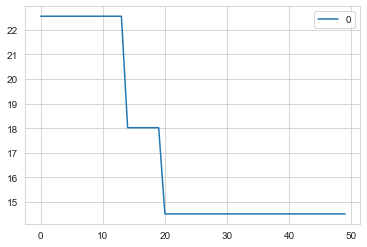

In [11]:
import pandas as pd
import matplotlib

%matplotlib inline

pd.DataFrame((np.array(es_p_best_fitness))).plot()

In [6]:
# seed the pseudorandom number generator

es_c_fitness_all = []
es_c_geno_all = []
for s in range(n_experiments):
    seed(s)
    # define range for input
    #bounds = asarray([[f.min_bounds[i], f.max_bounds[i]] for i in range(chrom_size)])
    # define the total iterations
    #n_iter = 50
    # define the maximum step size
    #step_size = 0.5
    # number of parents selected
    #mu = 25
    # the number of children generated by parents
    #lam = 50
    # perform the evolution strategy (mu, lambda) search
    [best, score], es_c_best_fitness, es_c_geno = es_comma(f, bounds, n_iter, step_size, mu, lam, decay_rate)
    #best, score = es_comma_mean(objective, bounds, n_iter, step_size, mu, lam, 80, 0.6)
    print('Done!')
    print('f(%s) = %f' % (best, score))
    es_c_fitness_all.append(es_c_best_fitness)
    es_c_geno_all.append(es_c_geno)

6.483112675004245
0, Best: f([-0.483272    0.95221542  0.99442374]) = 22.52744
0, Best: f([-2.18454314  0.99342662  0.92434057]) = 13.73307
100
5.921896071706929
1, Best: f([0.98553901 2.08024519 0.03090186]) = 6.77318
100
5.164250277071454
100
4.967467742312813
100
4.911873392585291
100
4.9845300361826705
100
5.371622811771826
100
5.365657479617396
100
5.532100340467759
8, Best: f([0.09024388 1.01499007 0.93926745]) = 4.24911
100
5.4614031484121455
100
5.658544760067688
100
5.549281222817953
100
5.534360378702655
100
5.851802010980793
100
5.596999501532095
100
5.200855208467862
100
5.353484129818514
100
5.5064179742863955
100
5.472390587118571
100
5.3481649734245496
100
5.642725822536467
100
5.879625012043299
100
5.752072468625596
100
5.890069391605224
100
5.998854116181503
100
5.760352977773375
100
5.769570360593139
100
5.806931299456721
100
5.629220532079714
100
5.7389189874694075
100
5.557295234197267
100
5.711261874643083
100
5.5139417604382865
32, Best: f([-0.05835     1.04219523

ValueError: too many values to unpack (expected 3)

In [13]:
print(len(es_c_best_fitness))

50


### Quantum versions

In [7]:
# evolution strategy (mu + lambda) algorithm
def qa_es_plus(sampler, objective, bounds, n_iter, step_size, mu, lam):
    #sampler = DWaveCliqueSampler(solver=dict(qpu=True))
    #sampler = neal.SimulatedAnnealingSampler()
    decay_rate =1
    best, best_eval = None, 1e+10
    # calculate the number of children per parent
    n_children = int(lam / mu)
    # initial population
    population = list()
    geno_divers =[]
    best_fitness = []
    pop_out = []
    for _ in range(lam):
        candidate = None
        while candidate is None or not in_bounds(candidate, bounds):
            candidate = bounds[:, 0] + rand(len(bounds)) * (bounds[:, 1] - bounds[:, 0])
        population.append(candidate)
    # perform the search
    for epoch in range(n_iter):
        # evaluate fitness for the population
        scores = [objective(c) for c in population]
        #best = population[np.argmin(np.array(scores))]
        for idx,i in enumerate(scores):
            if i < best_eval:
                best, best_eval = population[idx], i
                print('%d, Best: f(%s) = %.5f' % (epoch, best, best_eval))
        # rank scores in ascending order
        #ranks = argsort(argsort(scores))
        # select the indexes for the top mu ranked solutions
        #selected = [i for i,_ in enumerate(ranks) if ranks[i] < mu]
        selected_pop, selected_scores = select_individuals_quantum(population, scores, mu, sampler)
        #if epoch >= 1:
            
            #selected_pop.append(best)
      #  ranked_selected = np.argsort(np.argsort(selected_scores))
        #selected_pop, selected_scores = np.array(selected_pop)[ranked_selected], np.array(selected_scores)[ranked_selected]
        #selected_pop, selected_scores = selected_pop[:mu], selected_scores[:mu]
        # create children from parents
        #print(len(selected_pop))
        pop = selected_pop
        geno_divers.append(calculate_pairwise_distance_population(pop))
        print(calculate_pairwise_distance_population(pop))
        children = list()
        for idx, i in enumerate(range(mu)):
            # check if this parent is the best solution ever seen
            #print(i)
    
            parent1 = best
            #parent1 = pop[random.randint(0,len(pop)-1)]
            #parent1 = pop[idx]
            #children.append(parent1)
            #children.append(best)
            # create children for parent
            for _ in range(n_children):
                child = None
                while child is None or not in_bounds(child, bounds):
                    parent2 = pop[random.randint(0,len(pop)-1)]
                    child, child_2 = breed_by_crossover(parent1, parent2)
                    child = child + randn(len(bounds)) * step_size
                    #child = child + np.random.randn(len(parent1)) * np.random.uniform(low=0.001, high=0.01)
                    #x_ti = population[np.random.choice(list(range(len(population))))]
                    #x_ti = selected_pop[np.random.choice(list(range(len(selected_pop))))]
                    #x_si = best
                    #child = x_si + np.random.uniform(low=0, high=1) * randn(len(bounds))
                    #child = x_si + (np.random.uniform(low=0, high=1) * (x_si-x_ti)) 
                children.append(child)
        # replace population with children
        population = children
        scores = [objective(c) for c in population]
        for idx, i in enumerate(scores):
            if i < best_eval:
                best, best_eval = population[idx], i
                print('%d, Best: f(%s) = %.5f' % (epoch, best, best_eval))
        population = children 
        pop_out.append(best)
        print(len(population))
        best_fitness.append(best_eval)
        #step_size *= decay_rate
    return [best, best_eval], best_fitness, geno_divers, pop_out

def qa_es_comma(sampler, objective, bounds, n_iter, step_size, mu, lam):
    #sampler = DWaveCliqueSampler(solver=dict(qpu=True))
    decay_rate =1
    best, best_eval = None, 1e+10
    # calculate the number of children per parent
    n_children = int(lam/mu)
    # initial population
    population = []
    geno_divers =[]
    best_fitness = []
    pop_out = []
    for _ in range(lam):
        candidate = None
        while candidate is None or not in_bounds(candidate, bounds):
            candidate = bounds[:, 0] + rand(len(bounds)) * (bounds[:, 1] - bounds[:, 0])
        population.append(candidate)
    # perform the search
    for epoch in range(n_iter):
        # evaluate fitness for the population
        scores = [objective(c) for c in population]
        for idx,i in enumerate(scores):
            if i < best_eval:
                best, best_eval = population[idx], i
                print('%d, Best: f(%s) = %.5f' % (epoch, best, best_eval))
        # rank scores in ascending order
        #ranks = argsort(argsort(scores))
        # select the indexes for the top mu ranked solutions
        #selected = [i for i,_ in enumerate(ranks) if ranks[i] < mu]
        selected_pop, selected_scores = select_individuals_quantum(population, scores, mu,sampler)
        #ranked_selected = np.argsort(np.argsort(selected_scores))
        #selected_pop, selected_scores = np.array(selected_pop)[ranked_selected], np.array(selected_scores)[ranked_selected]
         #selected_pop, selected_scores = selected_pop[:mu], selected_scores[:mu]
        # create children from parents
        #print(len(selected_pop))
        pop = selected_pop
        geno_divers.append(calculate_pairwise_distance_population(pop))
        print(calculate_pairwise_distance_population(pop))
        children = []
        for idx, i in enumerate(range(mu)):
            # check if this parent is the best solution ever seen
            #print(i)
            #if i == mu:
            #    parent1 = best
            #parent1 = pop[random.randint(0,len(pop)-1)]
            #else:
                #parent1 = pop[idx-1]
            #parent1 = pop[random.randint(0,len(pop)-1)]
            parent1 = pop[idx]
            #children.append(parent1)
            #children.append(i)
            # create children for parent
            for _ in range(n_children):
                child = None
                while child is None or not in_bounds(child, bounds):
                    parent2 = pop[random.randint(0,len(pop)-1)]
                    child, child_2 = breed_by_crossover(parent1, parent2)
                    #child = pop[random.randint(0,len(pop)-1)]
                    child = child + randn(len(bounds)) * step_size
                    #child = child + np.random.randn(len(parent1)) * np.random.uniform(low=0.001, high=0.01)
                    #x_ti = population[np.random.choice(list(range(len(population))))]
                    #x_ti = selected_pop[np.random.choice(list(range(len(selected_pop))))]
                    #x_si = best
                    #child = x_si + np.random.uniform(low=0, high=1) * randn(len(bounds))
                    #child = x_si + (np.random.uniform(low=0, high=1) * (x_si-x_ti)) 
                children.append(child)
        # replace population with children
        population = children
        print(len(population))
        best_fitness.append(best_eval)
        pop_out.append(best)
        #step_size *= decay_rate
    return [best, best_eval], best_fitness, geno_divers, pop_out

def qa_es_plus_mean(objective, bounds, n_iter, step_size, mu, lam, pop_size, decay_rate):
    best, best_eval = None, 1e+10
    # calculate the number of children per parent
    n_children = int(lam / mu)
    # initial population
    population = list()
    for _ in range(lam):
        candidate = None
        while candidate is None or not in_bounds(candidate, bounds):
            candidate = bounds[:, 0] + rand(len(bounds)) * (bounds[:, 1] - bounds[:, 0])
        population.append(candidate)
    # perform the search
    for epoch in range(n_iter):
        # evaluate fitness for the population
        scores = [objective(c) for c in population]
        for idx, i in enumerate(scores):
            if i < best_eval:
                best, best_eval = population[idx], i
        # rank scores in ascending order
        #print(scores)
        #print(argsort(scores))
        #ranks = argsort(argsort(scores))
        
        #print(ranks)
        # select the indexes for the top mu ranked solutions
        #selected = [population[i] for i,_ in enumerate(ranks) if ranks[i] < mu]
        selected_pop, selected_scores = select_individuals_quantum(population, scores, mu)
        #print(selected)
        # create children from parents
        mean_selected = np.array(selected_pop).mean(axis=0)
        print("mean: ", mean_selected)
        print("best score: ", best_eval)
        print("mean eval: ", objective(mean_selected))
        #print(mean_selected)
        children = []
        children.append(mean_selected)
        for _ in range(pop_size-1):
                child = None
                while child is None or not in_bounds(child, bounds):
                    child = mean_selected + (randn(len(bounds)) * (step_size * decay_rate))
                children.append(child)
        # replace population with children
        population = children
    return [best, best_eval]


In [15]:

qa_c_fitness_all2 = []
qa_c_geno_all2 = []
#from dwave.system import LeapHybridSampler
import neal
#sampler = neal.SimulatedAnnealingSampler()
import greedy
sampler = greedy.SteepestDescentSampler()
#sampler = LeapHybridSampler()
for s in range(n_experiments):
    
    seed(s)
    # define range for input
    #bounds = asarray([[f.min_bounds[i], f.max_bounds[i]] for i in range(chrom_size)])
    # define the total iterations
    #n_iter = 50
    # define the maximum step size
    #step_size = 0.5
    # number of parents selected
    #mu = 25
    # the number of children generated by parents
    #lam = 50
    # perform the evolution strategy (mu + lambda) search
    [best, score], qa_c_best_fitness, qa_c_geno = qa_es_comma(sampler, f, bounds, n_iter, step_size, mu, lam)
    #best, score = qa_es_plus_mean(objective, bounds, n_iter, step_size, mu, lam, 80, 0.6)
    print('Done!')
    print('f(%s) = %f' % (best, score))
    qa_c_fitness_all2.append(qa_c_best_fitness)
    qa_c_geno_all2.append(qa_c_geno)

0, Best: f([0.48813504 2.15189366 1.02763376]) = 30.26635
0, Best: f([-1.16558481  2.91725038  0.2889492 ]) = 28.63804
0, Best: f([0.76157334 0.92041931 0.72251906]) = 24.16505
0, Best: f([-1.88055005 -1.01778938 -2.90156251]) = 17.59304
6.727067551791226
100
1, Best: f([-1.08434463 -0.07918295  0.23447147]) = 12.84692
1, Best: f([-0.89113384  0.94467339 -0.8763333 ]) = 8.17225
6.027618921426026
100
6.343712868048558
100
6.391482092237956
100
6.1364847070721025
100
5.701751886030623
100
5.901893070802639
100
5.549926113530018
100
8, Best: f([-0.99500631 -0.08758429 -0.13156305]) = 5.72276
5.007543295703181
100
5.868172474032323
100
5.782628455141128
100
5.3024359577981945
100
5.082480094500138
100
5.433371826072128
100
5.6149249050575225
100
5.058550535584469
100
5.240812864179154
100
5.208871487826056
100
5.177553819789898
100
5.231433636746496
100
5.559242016754554
100
21, Best: f([-0.88605968 -1.00310888  0.0161263 ]) = 4.29981
5.452951012491599
100
5.684955199358244
100
5.757031147

In [16]:

qa_fitness_all2 = []
qa_geno_all2 = []
for s in range(n_experiments):
    
    seed(s)
    # define range for input
    #bounds = asarray([[f.min_bounds[i], f.max_bounds[i]] for i in range(chrom_size)])
    # define the total iterations
    #n_iter = 50
    # define the maximum step size
    #step_size = 0.5
    # number of parents selected
    #mu = 25
    # the number of children generated by parents
    #lam = 50
    # perform the evolution strategy (mu + lambda) search
    [best, score], qa_best_fitness, qa_geno = qa_es_plus(sampler, f, bounds, n_iter, step_size, mu, lam)
    #best, score = qa_es_plus_mean(objective, bounds, n_iter, step_size, mu, lam, 80, 0.6)
    print('Done!')
    print('f(%s) = %f' % (best, score))
    qa_fitness_all2.append(qa_best_fitness)
    qa_geno_all2.append(qa_geno)
    

0, Best: f([0.48813504 2.15189366 1.02763376]) = 30.26635
0, Best: f([-1.16558481  2.91725038  0.2889492 ]) = 28.63804
0, Best: f([0.76157334 0.92041931 0.72251906]) = 24.16505
0, Best: f([-1.88055005 -1.01778938 -2.90156251]) = 17.59304
6.814252580923028
0, Best: f([-2.1603476  -0.93012923  1.92243761]) = 16.00065
100
4.698059616430275
1, Best: f([-2.13280596 -0.99280665 -1.9244584 ]) = 13.63782
1, Best: f([-3.07541238 -1.03342702  1.03225332]) = 13.11780
100
3.6423183413839544
2, Best: f([-0.80168097  1.0700402  -0.02107572]) = 9.63803
100
3.2595629052327384
100
3.1665791200819444
4, Best: f([0.08359161 0.99298675 0.13123565]) = 5.57914
100
3.4010813260781334
5, Best: f([ 0.07008703  0.89091628 -0.94867691]) = 5.42644
100
3.488538953531183
100
3.3526851254720182
100
3.07778157910601
100
3.1714497842250493
9, Best: f([ 1.06565936 -0.0077199  -1.07306296]) = 4.17324
100
3.4821671877045266
100
3.3485980856700976
100
2.9678472815642225
12, Best: f([ 0.03594858 -1.05052965 -0.01552242]) =

In [17]:
print(qa_fitness_all2)

[[16.00064780737141, 13.117797711401202, 9.638034038681683, 9.638034038681683, 5.579142199927402, 5.426441480805861, 5.426441480805861, 5.426441480805861, 5.426441480805861, 4.173242684484077, 4.173242684484077, 4.173242684484077, 1.9064473141573401, 1.9064473141573401, 1.9064473141573401, 1.9064473141573401, 1.9064473141573401, 1.9064473141573401, 1.9064473141573401, 1.9064473141573401, 1.9064473141573401, 1.9064473141573401, 1.9064473141573401, 1.9064473141573401, 1.9064473141573401, 1.9064473141573401, 1.9064473141573401, 1.9064473141573401, 1.9064473141573401, 1.9064473141573401, 1.9064473141573401, 1.9064473141573401, 1.9064473141573401, 1.9064473141573401, 1.9064473141573401, 1.9064473141573401, 1.9064473141573401, 1.9064473141573401, 1.9064473141573401, 1.9064473141573401, 1.9064473141573401, 1.9064473141573401, 1.9064473141573401, 1.9064473141573401, 1.9064473141573401, 1.9064473141573401, 1.9064473141573401, 1.9064473141573401, 1.9064473141573401, 1.9064473141573401]]


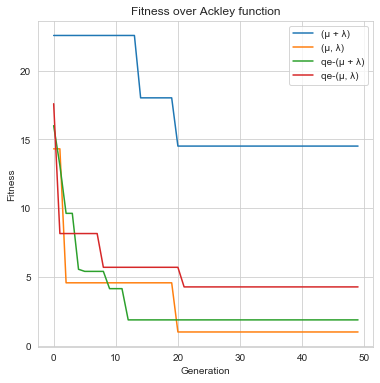

<Figure size 432x288 with 0 Axes>

In [18]:
import seaborn as sns
import pandas as pd

import matplotlib.pyplot as plt
plt.ioff()
sns.set_style('whitegrid')
plot = pd.DataFrame()

plot['(μ + λ)'] = np.array(es_p_fitness_all).mean(axis=0)
plot['(μ, λ)'] = np.array(es_c_fitness_all).mean(axis=0)
#plot['(μ-tournament)'] = np.log(np.array(es_t_fitness_all).mean(axis=0))
plot['qe-(μ + λ)'] = np.array(qa_fitness_all2).mean(axis=0)
plot['qe-(μ, λ)'] = np.array(qa_c_fitness_all2).mean(axis=0)
#plot.title("Average of Best Fitness over Ackley function: 20 shots")
#plot.xlabel("Generation")
#plot.ylabel("Log of Best fitness")

plot.plot(title="Fitness over Ackley function", xlabel="Generation", ylabel="Fitness", figsize=(6,6))
#sns.lineplot(data=plot,title="Average of Best Fitness over Ackley function: 20 shots", xlabel="Generation", ylabel="Log of Best fitness", figsize=(6,6))
plt.show()

plt.savefig('./es_geno_diversity_110522.png')

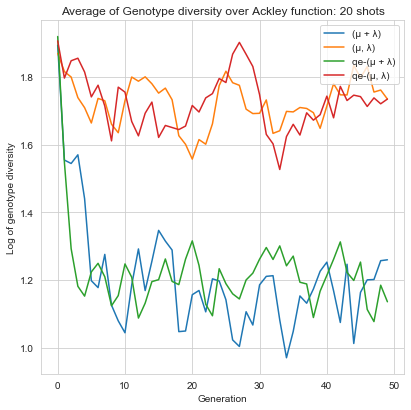

<Figure size 576x576 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [19]:
plot = pd.DataFrame()

plot['(μ + λ)'] = np.log(np.array(es_p_geno_all).mean(axis=0))
plot['(μ, λ)'] = np.log(np.array(es_c_geno_all).mean(axis=0))
#plot['(μ-tournament)'] = np.log(np.array(es_t_geno_all).mean(axis=0))
plot['qe-(μ + λ)'] = np.log(np.array(qa_geno_all2).mean(axis=0))
plot['qe-(μ, λ)'] = np.log(np.array(qa_c_geno_all2).mean(axis=0))

plot.plot(title="Average of Genotype diversity over Ackley function: 20 shots", xlabel="Generation", ylabel="Log of genotype diversity", legend=1, figsize =(6.5,6.5))
plt.legend(loc='upper right')
plt.figure(figsize=(8, 8))
plt.show()

plt.savefig('./es_geno_diversity_110522.png')

In [20]:
np.random.choice(2, 1)[0]

1

In [21]:
### All optproblems test functions

In [35]:
from optproblems.continuous import Weierstrass, Schaffer7, LunacekTwoRastrigins, Ackley, Rastrigin, Branin, FletcherPowell, GoldsteinPrice, Griewank, Vincent,Himmelblau,SixHumpCamelback
import pickle
#from mpl_toolkits.mplot3d import Axes3D
#%matplotlib inline
chrom_size = 2
n_experiments = 1
n_iter = 50
step_size = 0.17
mu = 50
lam = 100

import greedy
sampler = greedy.SteepestDescentSampler()

fs = [LunacekTwoRastrigins]
#fs2 = [Branin,GoldsteinPrice,Himmelblau,SixHumpCamelback]

experiment_results = {}

for func in fs:
    try:
        f =func(num_variables=chrom_size, name=str(func.__name__))
    
    except:
        f = func()
    #step_size = 0.1

    #r_min, r_max = 0., 10.
    try:

        r_min, r_max = f.min_bounds[0], f.max_bounds[0]

    except:
        r_min, r_max = -5, 5.
        
    experiment_results[func.__name__] = {}
        
    bounds = asarray([[r_min, r_max] for i in range(chrom_size)])    
        
    qa_fitness_all2 = []
    qa_geno_all2 = []
    qa_pop_all = []
    qa_c_fitness_all2 = []
    qa_c_geno_all2 = []
    qa_c_pop_all = []
    es_c_fitness_all = []
    es_c_geno_all = []
    es_c_pop_all = []
    es_p_fitness_all = []
    es_p_geno_all = [] 
    es_p_pop_all = []
    for s in range(n_experiments):
       
        [best, score], qa_best_fitness, qa_geno, qa_pop = qa_es_plus(sampler, f, bounds, n_iter, step_size, mu, lam)
        #best, score = qa_es_plus_mean(objective, bounds, n_iter, step_size, mu, lam, 80, 0.6)
        print('Done!')
        print('f(%s) = %f' % (best, score))
        qa_fitness_all2.append(qa_best_fitness)
        qa_geno_all2.append(qa_geno)
        qa_pop_all.append(qa_pop)

        [best, score], qa_c_best_fitness, qa_c_geno, qa_c_pop = qa_es_comma(sampler, f, bounds, n_iter, step_size, mu, lam)
        #best, score = qa_es_plus_mean(objective, bounds, n_iter, step_size, mu, lam, 80, 0.6)
        print('Done!')
        print('f(%s) = %f' % (best, score))
        qa_c_fitness_all2.append(qa_c_best_fitness)
        qa_c_geno_all2.append(qa_c_geno)
        qa_c_pop_all.append(qa_c_pop)

        [best, score], es_c_best_fitness, es_c_geno, es_c_pop = es_comma(f, bounds, n_iter, step_size, mu, lam, decay_rate)
        #best, score = es_comma_mean(objective, bounds, n_iter, step_size, mu, lam, 80, 0.6)
        print('Done!')
        print('f(%s) = %f' % (best, score))
        es_c_fitness_all.append(es_c_best_fitness)
        es_c_geno_all.append(es_c_geno)
        es_c_pop_all.append(es_c_pop)

        [best, score], es_p_best_fitness, es_p_geno, es_p_pop = es_plus(f, bounds, n_iter, step_size, mu, lam, decay_rate)
        print('Done!')
        print('f(%s) = %f' % (best, score))
        es_p_fitness_all.append(es_p_best_fitness)
        es_p_geno_all.append(es_p_geno)
        es_p_pop_all.append(es_p_pop)
        
            
    
    experiment_results[func.__name__]["qa_p"] = [qa_fitness_all2, qa_geno_all2,qa_pop_all]
    experiment_results[func.__name__]["qa_c"] = [qa_c_fitness_all2, qa_c_geno_all2,qa_c_pop_all]
    experiment_results[func.__name__]["es_p"] = [es_p_fitness_all,es_p_geno_all,es_p_pop_all]
    experiment_results[func.__name__]["es_c"] = [es_c_fitness_all,es_c_geno_all,es_c_pop_all]

  
        


0, Best: f([2.58766944 1.28929148]) = 10.50891
0, Best: f([1.62585548 4.5452597 ]) = 8.31589
0, Best: f([-2.66131543 -1.59289279]) = 7.21607
4.918562976888928
0, Best: f([-2.4548664  -4.58515403]) = 6.14682
0, Best: f([-2.65538907 -1.49285229]) = 5.44798
0, Best: f([-2.51912178 -1.46962832]) = 1.31565
100
3.262121338550591
100
3.207792875552242
2, Best: f([-2.44729012 -2.45678112]) = 0.91452
100
3.572578760202119
3, Best: f([-2.53510991 -2.451801  ]) = 0.70097
100
3.313438627092163
100
3.4223933942833233
100
3.1506976230779116
6, Best: f([-2.51492336 -2.47889763]) = 0.13237
100
2.9345362832509294
100
2.411999494398779
100
2.7818502824742004
100
2.803642509670851
100
2.4459474816612143
100
2.3223402818432755
100
2.138445752274327
100
1.691469930171027
100
1.8158476115196427
100
1.8391037437610958
100
1.7676795908629601
100
1.776252950724566
100
1.926590044599598
100
1.665452396063617
20, Best: f([-2.4849501  -2.48001393]) = 0.12405
100
1.4164187434561757
100
1.2184605328630798
22, Best:

In [36]:
experiment_names = (list(experiment_results.keys()))
for i in experiment_names[:-1]:
    """"
    plot['(μ + λ)'] = np.array(es_p_fitness_all).mean(axis=0)
    plot['(μ, λ)'] = np.array(es_c_fitness_all).mean(axis=0)
    #plot['(μ-tournament)'] = np.log(np.array(es_t_fitness_all).mean(axis=0))
    plot['qe-(μ + λ)'] = np.array(qa_fitness_all2).mean(axis=0)
    plot['qe-(μ, λ)'] = np.array(qa_c_fitness_all2).mean(axis=0)
    #plot.title("Average of Best Fitness over Ackley function: 20 shots")
    #plot.xlabel("Generation")
    #plot.ylabel("Log of Best fitness")

    plot.plot(title="Fitness over Ackley function", xlabel="Generation", ylabel="Fitness", figsize=(6,6))
    #sns.lineplot(data=plot,title="Average of Best Fitness over Ackley function: 20 shots", xlabel="Generation", ylabel="Log of Best fitness", figsize=(6,6))
    plt.show()
    """
    
    
       
    print(i)
    data = []
    for j in experiment_results[i].keys():
       
        print(j)
        #print(np.array(experiment_results[i][j][0]).shape)
        #print(np.array(experiment_results[i][j][0]))
        print(np.mean(np.array(experiment_results[i][j][0]), axis=0))
        #print(np.std(np.array(experiment_results[i][j][0]), axis=0)[-1])
        #for k in experiment_results[i][j]:
        #print(np.mean(k, axis=0))
            #print(k[0])
            #plot['(μ + λ)'] = np.array(es_p_fitness_all).mean(axis=0)
            #plot['(μ, λ)'] = np.array(es_c_fitness_all).mean(axis=0)
    
            #plot['qe-(μ + λ)'] = np.array(qa_fitness_all2).mean(axis=0)
            #plot['qe-(μ, λ)'] = np.array(qa_c_fitness_all2).mean(axis=0)
    
    
    
    
    

In [37]:
import pickle


with open('./qaes_pop_viz_best_020923', 'wb') as f:
    pickle.dump(experiment_results, f)
    


In [ ]:
from  IOHexperimenter.IOH_function import IOH_function
from IOHexperimenter import IOH_function, IOH_logger

In [ ]:
c_results = {}
fs =[4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]

In [ ]:
fs[:-1]

## Scratch

## Scratch

In [ ]:
import scipy
from scipy import stats

In [ ]:
v =[3.3,1.,-2]
u = [4,-2.2,8]

In [ ]:
print(stats.pearsonr(u,v)[0])

In [ ]:
randn(len(v))

In [ ]:
index = [1,2,3]
np.random.choice(index)

In [ ]:
# seed the pseudorandom number generator


decay_rate = 1
es_t_fitness_all = []
es_t_geno_all = []
for s in range(2):
    seed(s)
    # define range for input
    bounds = asarray([[-5.0, 5.0], [-5.0, 5.0]])
    # define the total iterations
    n_iter = 50
    # define the maximum step size
    step_size = 0.5
    # number of parents selected
    mu = 5
    # the number of children generated by parents
    lam = 30
    # perform the evolution strategy (mu + lambda) search
    [best, score], es_t_best_fitness, es_t_geno = es_tournament(objective, bounds, n_iter, step_size, mu, lam, decay_rate)
    print('Done!')
    print('f(%s) = %f' % (best, score))
    es_t_fitness_all.append(es_t_best_fitness)
    es_t_geno_all.append(es_t_geno)